In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import torch
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import animation
import torch.nn as nn
import torch.nn.functional as F
import os
import wandb
import cProfile
import pstats

from FNO import FNOModel
from UNet import UNet3D
from utils import *

print("CUDA Available: ", torch.cuda.is_available())

%cd
pathToFolderPC = r'\Documents\2024-II\AutoregressiveNeuralOperators'
pathToFolderLAPTOP = r'Documents\2024-II\prep\AutoregressiveNeuralOperators'

%cd $pathToFolderLAPTOP
#%cd $pathToFolderPC

trainingOn = False
modeltype = 'FNO' # 'FNO' or 'UNet'

CUDA Available:  True
C:\Users\20183172
C:\Users\20183172\Documents\2024-II\prep\AutoregressiveNeuralOperators


# To do
- Investigate OG dataset
- Create FeNics Env Snellius
- Use SIMM loss instead of MSE?
- Fix issue pushforward training 
- Create new environment called grad


# Done
- Make NS dataset
- Make FNO
- Make model autoregressive + pushforward
- Rollout -> only loss at final step
- Make Simple U-Net
- Setup WandB
- Get snellius credits
- Setup small repo
- Test num_workers= and pin_memory=
- Create gifmaker
- Get OG dataset

In [ ]:
pathToData = r'data\t1-t50VorticityZ-32x32-v1e-3-T50-N40.npy'
data = np.load(pathToData)
data.shape

(40, 32, 32, 50)

In [3]:
tensorFormat = torch.tensor(data, dtype=torch.float32)
distribution=[0.8, 0.15, 0.05]
timeDistribution=[0.2, 0.8]

nSamples = len(tensorFormat)
bigT = 10
tensorFormatX, tensorFormatY = (
    tensorFormat[..., :bigT],
    tensorFormat[..., -bigT:],
)
print(tensorFormatX.shape, tensorFormatY.shape)
print(tensorFormat.shape[-1]-bigT)

torch.Size([40, 32, 32, 10]) torch.Size([40, 32, 32, 10])
40


In [4]:
trainingIdx, validationIdx, _ = [int(nSamples * k) for k in distribution]
trainingX, validationX, testX = (
    tensorFormatX[:trainingIdx, ...],
    tensorFormatX[trainingIdx : trainingIdx + validationIdx, ...],
    tensorFormatX[trainingIdx + validationIdx :, ...],
)

trainingY, validationY, testY = (
    tensorFormatY[:trainingIdx, ...],
    tensorFormatY[trainingIdx : trainingIdx + validationIdx, ...],
    tensorFormatY[trainingIdx + validationIdx :, ...],
)
print(trainingX.shape, validationX.shape, testX.shape)
print(trainingY.shape, validationY.shape, testY.shape)

fullValidationData = tensorFormat[trainingIdx : trainingIdx + validationIdx, ...]
fullTrainingData = tensorFormat[:trainingIdx, ...].clone()
print(fullTrainingData.shape)

torch.Size([32, 32, 32, 10]) torch.Size([6, 32, 32, 10]) torch.Size([2, 32, 32, 10])
torch.Size([32, 32, 32, 10]) torch.Size([6, 32, 32, 10]) torch.Size([2, 32, 32, 10])
torch.Size([32, 32, 32, 50])


In [5]:
#trainingX = trainingX.unsqueeze_(3).expand(-1, -1, -1, bigT, -1)
training = TensorDataset(trainingX, trainingY)
print(trainingX.shape, trainingY.shape)

#validationX = validationX.unsqueeze_(3).expand(-1, -1, -1, bigT, -1)
validation = TensorDataset(validationX, validationY)

#testX = testX.unsqueeze_(3).expand(-1, -1, -1, bigT, -1)
test = TensorDataset(testX, testY)

torch.Size([32, 32, 32, 10]) torch.Size([32, 32, 32, 10])


In [6]:
gpuForLoader = [False, True]
workers = [1,1,2,4,8,12]
#numworkersTest(training, workers, 8)

In [7]:
batchSize = 8
shuffleTraining = True
trainingDataLoader = DataLoader(
    training, batch_size=batchSize, shuffle=shuffleTraining, num_workers=1, pin_memory=True#2
)

validationDataLoader = DataLoader(
    validation, batch_size=batchSize, shuffle=False, num_workers=1, pin_memory=True
)

testDataLoader = DataLoader(
    test, batch_size=batchSize, shuffle=False, num_workers=1, pin_memory=True)

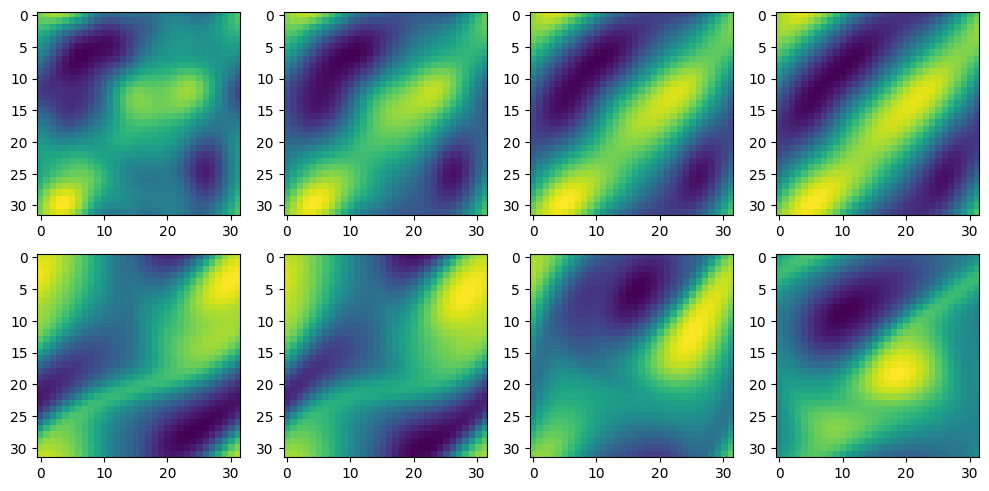

In [8]:
fig, ax = plt.subplots(2, 4, figsize=(10, 5))
ax[0,0].imshow(trainingX[0, :, :, 0], cmap='viridis')
ax[0,1].imshow(trainingX[0, :, :, 1], cmap='viridis')
ax[0,2].imshow(trainingX[0, :, :, 2], cmap='viridis')
ax[0,3].imshow(trainingX[0, :, :, 3], cmap='viridis')
ax[1,0].imshow(trainingY[0, :, :, 0], cmap='viridis')
ax[1,1].imshow(trainingY[0, :, :, 1], cmap='viridis')
ax[1,2].imshow(trainingY[0, :, :, 5], cmap='viridis')
ax[1,3].imshow(trainingY[0, :, :, 9], cmap='viridis')
plt.tight_layout()
plt.show()

In [13]:
if modeltype == 'FNO':
    model = FNOModel(
        in_neurons=20, hidden_neurons=20, out_neurons=20, modesSpace=8, modesTime=8, time_padding=8, input_size = 13, 
        learning_rate=0.001, restart_at_epoch_n=0, train_loader=trainingDataLoader, loss_function='MSE'
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.optimizer = torch.optim.Adam(model.parameters())

In [14]:
if trainingOn and modeltype == 'FNO':
    epochs = 30
    wandb.init(project="testFNO", config={
        "epochs": epochs,
        "learning_rate": model.learning_rate,
        "loss_function": model.loss_name,
    })

    for epoch in range(epochs):
        train_loss = 0
        model.train()
        for batch_idx, (x, y) in enumerate(trainingDataLoader):
            x, y = x.to(device), y.to(device)
            #print(x.shape)
            
            with torch.no_grad():
                for tstep in range(1, 4):
                    
                    x = x.unsqueeze_(3).expand(-1, -1, -1, bigT, -1)
                    meshgrid = get_meshgrid(x.shape, tstep).to(x.device)
                    x = torch.concat((x, meshgrid), dim=-1)  # [B, X, Y, T, 3 + T_in]
                    y_hat = model(x)
                    x = y_hat  
            
            tstep = 4
            x = x.unsqueeze_(3).expand(-1, -1, -1, bigT, -1)
            meshgrid = get_meshgrid(x.shape, tstep).to(x.device)
            x = torch.concat((x, meshgrid), dim=-1) 
            
            model.optimizer.zero_grad()
            y_hat = model(x)
            train_loss = model.loss_function(y_hat, y)
            train_loss.backward()
            model.optimizer.step()
            
            train_loss += train_loss.item()  
        avg_train_loss = train_loss / len(trainingDataLoader)
        print(train_loss, len(trainingDataLoader))

        model.eval()
        mean_val_loss = 0
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(validationDataLoader):
                #print(x.shape)
                x, y = x.to(device), y.to(device)
                for tstep in range(1, 5):
                    x = x.unsqueeze_(3).expand(-1, -1, -1, bigT, -1)
                    meshgrid = get_meshgrid(x.shape, tstep).to(x.device)
                    x = torch.concat((x, meshgrid), dim=-1) 
                    y_hat = model(x)
                    x = y_hat 

                val_loss = model.loss_function(y_hat, y)
                val_loss += val_loss.item()
            avg_val_loss = val_loss / len(validationDataLoader)
        print(val_loss, len(validationDataLoader))

        wandb.log({
                "epoch": epoch + 1,
                "train_loss": avg_train_loss,
                "val_loss": avg_val_loss,
            })

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    wandb.finish()


In [15]:
if modeltype == 'UNet':
    model = UNet3D(in_neurons=1, out_neurons=1)
    x = torch.randn(4, 32, 32, 10) 
    x.unsqueeze_(1) # add dimension for the channels
    output = model(x)
    print(f"Input shape: {x.shape}, Output shape: {output.shape}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.optimizer = torch.optim.Adam(model.parameters())

In [16]:
if trainingOn and modeltype == 'UNet':
    epochs = 200
    wandb.init(project="testUNet", config={
        "epochs": epochs,
        "loss_function": model.loss_function, 
    })

    for epoch in range(epochs):
        train_loss = 0
        model.train()
        for batch_idx, (x, y) in enumerate(trainingDataLoader):
            x, y = x.to(device), y.to(device)
            #print(x.shape)
            
            with torch.no_grad():
                for tstep in range(1, 4):
                    # Expand and append meshgrid
                    #x = x.unsqueeze_(3).expand(-1, -1, -1, bigT, -1)
                    #meshgrid = get_meshgrid(x.shape, tstep).to(x.device)
                    #x = torch.concat((x, meshgrid), dim=-1)  # [B, X, Y, T, 3 + T_in]
                    #print(x.shape)
                    x.unsqueeze_(1)
                    y_hat = model(x)
                    #print(y_hat.shape)
                    x = y_hat  
                    
            tstep = 4
            #x = x.unsqueeze_(3).expand(-1, -1, -1, bigT, -1)
            #meshgrid = get_meshgrid(x.shape, tstep).to(x.device)
            #x = torch.concat((x, meshgrid), dim=-1)  # [B, X, Y, T, 3 + T_in]
            
            model.optimizer.zero_grad()
            x.unsqueeze_(1)
            y_hat = model(x)
            #print(y_hat.shape, y.shape)
            train_loss = model.loss_function(y_hat, y)
            train_loss.backward()
            model.optimizer.step()
            
            train_loss += train_loss.item()  # Accumulate loss for the epoch
        avg_train_loss = train_loss / len(trainingDataLoader)
        #print(train_loss, len(trainingDataLoader))

        model.eval()
        mean_val_loss = 0
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(validationDataLoader):
                #print(x.shape)
                x, y = x.to(device), y.to(device)
                for tstep in range(1, 5):
                    #x = x.unsqueeze_(3).expand(-1, -1, -1, bigT, -1)
                    #meshgrid = get_meshgrid(x.shape, tstep).to(x.device)
                    #x = torch.concat((x, meshgrid), dim=-1) 
                    x.unsqueeze_(1)
                    y_hat = model(x)
                    x = y_hat 

                val_loss = model.loss_function(y_hat, y)
                val_loss += val_loss.item()
            avg_val_loss = val_loss / len(validationDataLoader)
        #print(val_loss, len(validationDataLoader))

        wandb.log({
                "epoch": epoch + 1,
                "train_loss": avg_train_loss,
                "val_loss": avg_val_loss,
            })
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    wandb.finish()

In [17]:
#torch.save(model.state_dict(), "models/NS_UNetmodel_v2.pth")

In [18]:
if modeltype == 'FNO':
    model.load_state_dict(torch.load("models/NS_FNOmodel_v1.pth"))
    #model.load_state_dict(torch.load("models/NS_FNOmodel_v1.pth", map_location=torch.device('cpu')))
elif modeltype == 'UNet':
    model.load_state_dict(torch.load("models/NS_UNetmodel_v1.pth"))
    #model.load_state_dict(torch.load("models/NS_UNetmodel_v1.pth", map_location=torch.device('cpu')))

C:\Users\20183172\AppData\Local\Temp\ipykernel_9800\2052891902.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/NS_FNOmodel_v1.pt

In [24]:
# rollout code for both models
if modeltype == 'FNO':
    model.eval()
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(trainingDataLoader): 
        #for batch_idx, (x, y) in enumerate(validationDataLoader):
            x, y = x.to(device), y.to(device)
            out = x.clone()
            for tstep in range(1, 5):
                x = x.unsqueeze_(3).expand(-1, -1, -1, bigT, -1)
                meshgrid = get_meshgrid(x.shape, tstep).to(device)
                x = torch.concat((x, meshgrid), dim=-1) # [B, X, Y, T, 3 + T_in]
                y_hat = model(x)
                x = y_hat
                out = torch.cat((out, x.clone()), dim=-1)
            #tstep = 4
            #x = x.unsqueeze_(3).expand(-1, -1, -1, bigT, -1)
            #meshgrid = get_meshgrid(x.shape, tstep).to(torch.device('cuda'))
            #x = torch.concat((x, meshgrid), dim=-1) # [B, X, Y, T, 3 + T_in]
            #y_hat = model(x)
            break
            
elif modeltype == 'UNet':
    # rollout code for the UNet model
    model.eval()
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(trainingDataLoader): # normally validation data
        #for batch_idx, (x, y) in enumerate(validationDataLoader):
            x, y = x.to(device), y.to(device)
            out = x.clone()
            for tstep in range(1, 5):
                
                x.unsqueeze_(1)
                y_hat = model(x)
                x = y_hat
                out = torch.cat((out, x.clone()), dim=-1) 
            break
else:
    print('Model type not recognized')


In [25]:
#%matplotlib widget
#sliderPlot(y, y_hat, batchSize=6, colormap='turbo')

In [26]:
fullTrainingData.shape, out.shape

(torch.Size([32, 32, 32, 50]), torch.Size([8, 32, 32, 50]))

In [27]:

#for batchNumber in range(out.shape[0]):
#    createGif(out[batchNumber,:,:,:].cpu(), modeltype + str(batchNumber), 'turbo')
#for batchNumber in range(out.shape[0]):
#    createGif(fullValidationData[batchNumber,:,:,:], "GroundTruth" + str(batchNumber), 'turbo')
for batchNumber in range(out.shape[0]):
    createGif(out[batchNumber,:,:,:].cpu(), 'train_' + modeltype + str(batchNumber), 'turbo')
for batchNumber in range(out.shape[0]):
    createGif(fullTrainingData[batchNumber,:,:,:], "train_GroundTruth" + str(batchNumber), 'turbo')


MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


In [28]:
# code from chatGPT

from PIL import Image, ImageSequence, ImageDraw, ImageFont

def combine_gifs_with_titles(gif_paths, titles, output_path):
    gifs = [Image.open(gif) for gif in gif_paths]

    # Check if all GIFs have the same number of frames
    frame_counts = [len(list(ImageSequence.Iterator(gif))) for gif in gifs]
    #print(set(frame_counts))
    if len(set(frame_counts)) > 1:
        raise ValueError("All GIFs must have the same number of frames.")

    # Get dimensions for combining
    widths, heights = zip(*(gif.size for gif in gifs))
    total_width = sum(widths)
    max_height = max(heights)
    title_height = 30  # Height for the title bar

    combined_frames = []

    # Font setup (default font)
    try:
        font = ImageFont.truetype("arialbd.ttf", 25)  # Use a system font
    except IOError:
        font = ImageFont.load_default()  # Fallback if the font isn't available

    for frames in zip(*(ImageSequence.Iterator(gif) for gif in gifs)):
        # Create a new blank image for the combined frame
        combined_frame = Image.new("RGBA", (total_width, max_height + title_height), (255, 255, 255, 255))

        # Draw titles
        draw = ImageDraw.Draw(combined_frame)
        x_offset = 0
        for title, width in zip(titles, widths):
            # Calculate text dimensions using textbbox
            text_bbox = draw.textbbox((0, 0), title, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]

            text_x = x_offset + (width - text_width) // 2
            draw.text((text_x, (title_height - text_height) // 2), title, fill="black", font=font)
            x_offset += width

        # Paste each frame below the title bar
        x_offset = 0
        for frame in frames:
            combined_frame.paste(frame, (x_offset, title_height))
            x_offset += frame.width

        combined_frames.append(combined_frame)

    # Save the combined GIF
    combined_frames[0].save(
        output_path,
        save_all=True,
        append_images=combined_frames[1:],
        loop=0,
        duration=gifs[0].info['duration']  # Use the frame duration of the first GIF
    )

# Paths to your GIF files and corresponding titles
for gifext in range(out.shape[0]):
    fileEnd = str(gifext) + ".gif"
    gif_paths = [
        r"output\train_FNO" + fileEnd,
        r"output\train_GroundTruth" + fileEnd,
        r"output\train_UNet" + fileEnd
    ]
    titles = ["FNO", "Ground Truth", "U-Net"]
    output_path = r"output\train_FNO+GT+UNet_" + str(gifext) + ".gif"
    combine_gifs_with_titles(gif_paths, titles, output_path)
